In [2]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

# Monte Carlo methods

Monte Carlo methods are a collection of methods that make use of random numbers, usually to try to determine some deterministic (non-random) property. Examples include
* Finding the properties (e.g., mean and variance) of some probability distribution
* Finding the expectation value of a function of a random variable

Many variations exist, and expressions such as "the Monte Carlo method" and "Monte Carlo simulations" may mean different things in different fields. Some examples and applications are described here: https://en.wikipedia.org/wiki/Monte_Carlo_method

We will return to this topic several times during the course, but here we will introduce some general ideas.

## The Central Limit Theorem

The Central Limit Theorem (CLT) exists in several variants. A useful one is the Lindeberg-Lévy CLT.

Suppose that $\{X_1, X_2, \ldots, X_N\}$ are independent samples from some probability distribution, $p$, with mean $\mu$ and variance $\sigma^2 < \infty$. Then $\mu_N = \frac{1}{N}\sum_{i=1}^N X_i$ is called the *sample mean*. If you draw $N$ samples several times, then $\mu_N$ will generally have a different value each time, such that $\mu_N$ is essentially a random variable. According to the *strong law of large numbers*, $\mu_N \to \mu$ as $N \to \infty$, almost surely. ("Almost surely" is a technical term that means "with probability 1". It basically means that you can construct counterexamples, but they have zero probability of occuring. For example, if you roll a 6-sided die $N$ times, then the average value will approach 3.5 with probability 1 as $N \to \infty$. You could imagine throwing a 6 every time, but the probability of this goes to 0 as $N \to \infty$.)


Furthermore, we have that the error in the sample mean is given by $E_N = \mu - \mu_N$, where $\mu$ is the *true* mean of the distribution (which will often be unknown). Then the Lindeberg-Lévy CLT say that the distribution of the error, $E_N$ in the sample mean is given by

$$ E_N \sim  \frac{1}{\sqrt{N}} \mathcal{N}(0, \sigma^2), $$

where $\mathcal{N}(0, \sigma^2)$ is a Gaussian distribution with zero mean and variance $\sigma^2$, and $\sigma^2$ is the (usually unknown) variance of the original distribution $p$.

#### The convergence with $1/\sqrt{N}$ is an important feature of Monte Carlo methods.

## Example: Sampling from the Maxwell distribution

In exercise 1, you are asked to plot a histogram of particle speeds, which should match the two-dimensional Maxwell-Boltzmann distribution. Here, we plot some samples drawn directly from the regular Maxwell distribution, as an example.

In [3]:
from scipy.stats import maxwell, norm

Mean = 1.59577, Variance = 0.45352


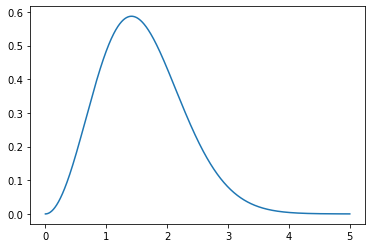

In [4]:
# Create a distribution object
p = maxwell()

# print theoretical mean and variance of distribution
mean, var = p.stats(moments = 'mv')
print(f'Mean = {mean:.5f}, Variance = {var:.5f}')

# Plot PDF for range from 0 to 5
x = np.linspace(0, 5, 1000)
plt.plot(x, p.pdf(x))

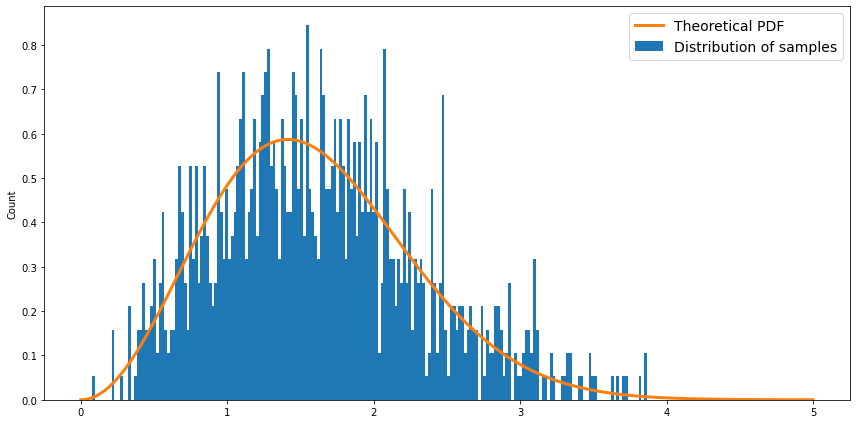

In [5]:
# Draw N random samples, and plot histogram
N = 1000
# draw N random variables with the .rvs() method of p
X = p.rvs(N)

fig = plt.figure(figsize = (12, 6))
plt.hist(X, bins = 200, density = True, label = 'Distribution of samples')
# Plot PDF for range from 0 to 5
x = np.linspace(0, 5, 1000)
plt.plot(x, p.pdf(x), lw = 3, label = 'Theoretical PDF')
plt.ylabel('Count')
plt.legend(fontsize = 14)
plt.tight_layout()

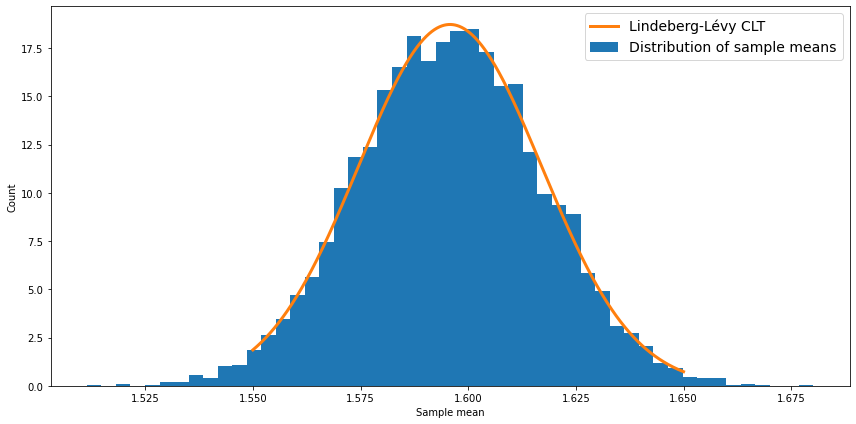

In [6]:
# Draw N random samples, and calculate mean M times
N = 1000
M = 10000


sample_means = np.zeros(M)
for i in range(M):
    # draw N random variables with the .rvs() method of p
    X = p.rvs(N)
    # Calcualte sample mean and store result
    sample_means[i] = np.sum(X)/N
    
#print(sample_means)
fig = plt.figure(figsize = (12, 6))
plt.hist(sample_means, bins = 50, density = True, label = 'Distribution of sample means')
# Plot theoretical distribution from Lindeberg-Lévy CLT
x = np.linspace(1.55, 1.65, 1000)
plt.plot(x, norm(loc = mean, scale = np.sqrt(var/N)).pdf(x), lw = 3, label = 'Lindeberg-Lévy CLT')
plt.xlabel('Sample mean')
plt.ylabel('Count')
plt.legend(fontsize = 14)
plt.tight_layout()

## See how sample mean converges as a function of $N$

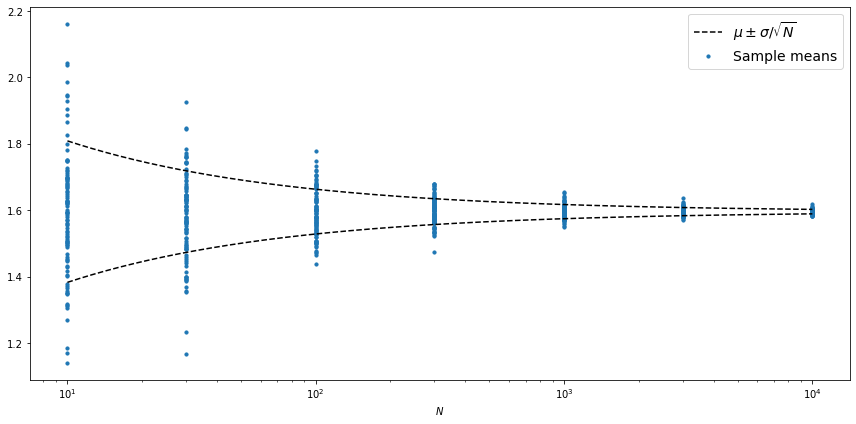

In [7]:
# Draw N random samples, and calculate mean M times
N_values = np.array([10, 30, 100, 300, 1000, 3000, 10000])
M = 100


sample_means = np.zeros((len(N_values), M))
for i, N in enumerate(N_values):
    for j in range(M):
        # draw N random variables with the .rvs() method of p
        X = p.rvs(N)
        # Calcualte sample mean and store result
        sample_means[i, j] = np.sum(X)/N

fig = plt.figure(figsize = (12, 6))
plt.scatter(np.ones((len(N_values), M))*N_values[:,None], sample_means, s = 10, label = 'Sample means')

# Draw theoretical convergence curves
x = np.linspace(10, 10000, 100001)
plt.plot(x, mean + np.sqrt(var/x), '--', c = 'k', label = '$\mu \pm \sigma/\sqrt{N}$')
plt.plot(x, mean - np.sqrt(var/x), '--', c = 'k')

# log scale the x-axis
plt.xscale('log')
plt.legend(fontsize = 14)
plt.xlabel('$N$')
plt.tight_layout()

## Markov Chain Monte Carlo

Markov Chain Monte Carlo is an approach for sampling from a probability distribution where it is difficult to draw samples. Typical examples where this is useful many-dimensional distributions, where the most probable values are gathered in a small fraction of the volume of the distribution.

The idea is that instead of drawing independent samples, we create a series of samples, where each one is a random perturbation of the previous sample. Such a series of random values is called a Markov Chain if it has the property that the next value only depends on the current value, not on any previous values. The trick then is to construct a Markov Chain that has the desired stationary distribution.


### Metropolis algorithm

Prerequisite:
* We must be able to evaluate $P^*(x)$, where $p(x) = \frac{P^*(x)}{\int_V P^*(x) dx}$ is the probability distribution we want. So $P^*(x)$ is proportional to the probability distribution, but does not itself have to be normalised. The point is that this allows us to compare the relative probability of two values, $x$ and $x'$.
* We must have a *proposal distribution*, $Q(x'|x)$ (probability to step from $x$ to $x'$) which is used to step from one value to the next. It can in principle be any distribution, but the choice of this distribution will affect the rate of convergence. We must also be able to draw samples from the proposal distribution.
* For now, we will assume for simplicity that the proposal distribution is symmetric, such that $Q(x'|x)=Q(x|x')$. If we need a non-symmetric proposal distribution, we can use the Metropolis-Hastings algorithm, which is very similar with one small adjustment.


#### Algorithm:
* First, generate a random value $x_0$. This is the first element in the Markov Chain.
* Then, repeat the following:
 * Draw a new random value, $x'$, from the proposal distribution, $Q(x'|x_i)$, where $x_i$ is the current value.
 * Calculate the value $a = \frac{P^*(x')}{P^*(x_i)}$.
 * If $a > 1$, then $x'$ is more probable than $x_i$. We accept the new value, and set $x_{i+1} = x'$ as the next element in the Markov Chain.
 * If $a <= 1$, then $x'$ is less probable than $x_i$. In this case, we accept the new value, with probability a:
  * Draw a uniform random number, $r \in [0, 1]$.
  * If $r \leq a$, we accept the value, and set $x_{i+1} = x'$ as the next element in the Markov Chain.
  * If $r > a$, we reject the value $x'$, and set $x_{i+1} = x_i$ as the next element in the Markov Chain.

It can be shown that a Markov Chain constructed with this algorithm will have the desired stationary distribution.

## Example: Using the Metropolis algorithm to sample from some odd distribution

In this case, we'll use
$$ P^*(x) = \sin^2(x) \exp(-x^2 / \sigma)$$
as our "probability distribution" (remember, it doesn't have to be normalised).

Then we'll use
$$ Q(x'|x) = \mathcal{U}(x - \Delta x/2, x + \Delta x/2) $$
as our proposal distribution. That is, uniform distribution of length $\Delta x$, centered on the current value $x$.


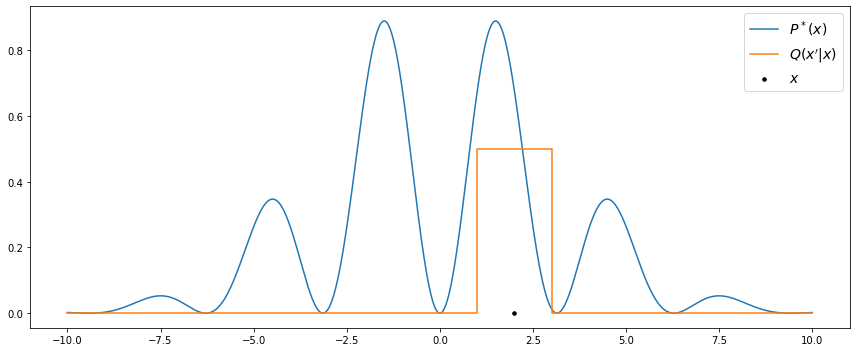

In [8]:
# Just some plots to illustrate a bit
sigma = 20
P = lambda x : np.sin(x)**2*np.exp(-x**2/sigma)


fig = plt.figure(figsize = (12,5))
# plot P*(x)
x = np.linspace(-10, 10, 10001)
plt.plot(x, P(x), label = '$P^*(x)$')
# Plot Q(x2|x1), as an illustration
dx = 2
x1 = 2
plt.scatter(x1, 0, marker = '.', s = 50, c = 'k', label = '$x$')
plt.plot([-10, x1-dx/2, x1-dx/2, x1+dx/2, x1+dx/2, 10], [0, 0, 1/dx, 1/dx, 0, 0], label = "$Q(x'|x)$" )
plt.legend(fontsize = 14)
plt.tight_layout()

In [9]:
# Function to make N steps with the Metropolis algorithm
def metropolis(x0, P, Q, N):
    # Array to store results
    markov_chain = np.zeros(N)
    # Store initial value
    markov_chain[0] = x0
    # Set x to first value
    x = x0
    for i in range(1, N):
        # Draw new proposed value
        x_ = Q(x)
        # Evaluate probabilities
        a = P(x_)/P(x)
        # Draw uniform random number on interval [0, 1]
        r = np.random.random()
        # Accept or reject
        if r < a:
            # Accepted
            x = x_
        else:
            # Rejected, do nothing
            pass
        # In both cases (rejected or accepted) write x to Markov Chain,
        # and proceed to next iteration
        markov_chain[i] = x
    return markov_chain

In [40]:
# Define P*
# This returns a (non-normalised) probability for a value x
sigma = 20
P = lambda x : 1e-3 + np.sin(x)**2*np.exp(-x**2/sigma)

# Define Q
# This returns a new value, x', given x
dx = 1
Q = lambda x : np.random.uniform(x-dx/2, x+dx/2)

x0 = 0
N = 100000
chain = metropolis(x0, P, Q, N)

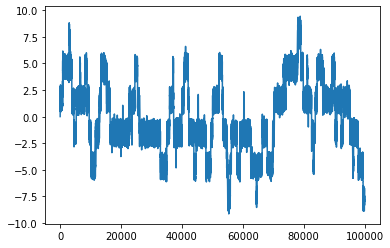

In [41]:
plt.plot(chain)

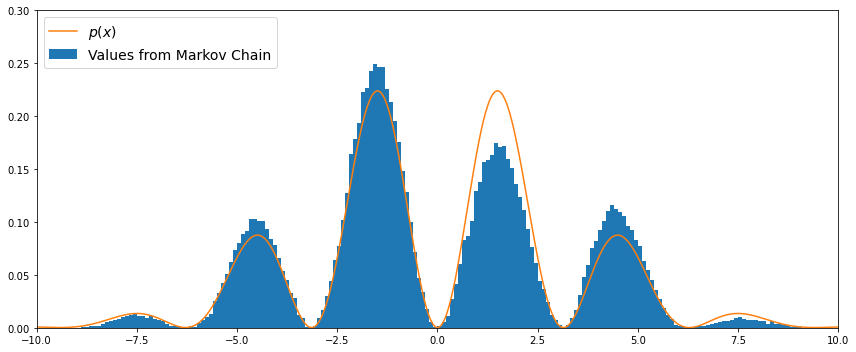

In [42]:
fig = plt.figure(figsize = (12, 5))
plt.hist(chain, bins = np.linspace(-20, 20, 401), density = True, label = 'Values from Markov Chain')
x = np.linspace(-10, 10, 10001)
plt.plot(x, P(x)/(np.sum(P(x)*(x[1]-x[0]))), label = '$p(x)$')
plt.legend(loc = 'upper left', fontsize = 14)
plt.xlim(x[0], x[-1])
plt.ylim(0, 0.3)
plt.tight_layout()

## So how many samples do we need?

The central limit theorem says that the errors in our estimates are proportional to $1/\sqrt{N}$, where $N$ is the number of _independent_ samples.

Key point: The elements in the Markov chain are _not_ independent samples!

We can check the autocorrelation to find out how many steps we must make, before the value is largely uncorrelated to the starting value.

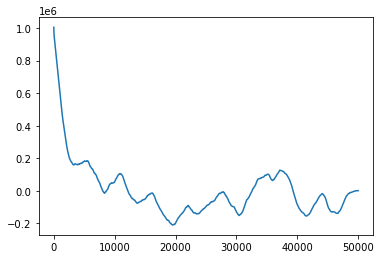

In [43]:
plt.plot(np.correlate(chain, chain, mode = 'same')[int(len(chain)/2):])
#plt.xlim(0, 500)

## Example: Metropolis algorithm for the 2D Ising model

We will consider the 2D Ising model:
* We have a system consisting of a quadratic grid of $N \times N$ points
 * Equal spacing in both directions
 * Periodic boundary conditions
* At each point, these is a spin, $s_i$, (think of it as a tiny magnet) and the full system of spins is called $\mathbf{S}$.
* A spin has lowest potential energy if it points in the same direction as it's nearest neighbours.
* The system also has a temperature:
 * High temperature means the spins have enough kinetic energy to flip around frequently
 * Low temperature means the spins tend to fall into the lowest temperature state
* For some temperature, $T$, we want to calculate the average direction of spins (also called the magnetisation)

The total potential energy, $E(\mathbf{S})$, of the system is given by
$$ E(\mathbf{S}) = -J \sum_{i,j} s_i, s_j, $$
where the sum is over all nearest-neighbour pairs of spins in $\mathbf{S}$. The probability that a system occupies a given state, $\mathbf{S}$, is proportional to
$$ P^*(\mathbf{S}) = \exp\big({-}\beta E(\mathbf{S})\big), \;\;\; \mathrm{where} \;\;\; \beta = \frac{1}{k_B T}. $$

How do we find the average magnetisation for a given temperature, $T$?

### One strategy: Generate random systems, take average weighted with $P^*(\mathbf{S})$
* Generating random systems is trivial
* Since we can calculate $P^*(\mathbf{S})$ for any system, we know how likely that system is, relative to all other systems
* Hence, a straightforward weighted average should in principle work.
* Problem: There is an absurd number of possible systems: $N = 2^{10 \times 10} = 1267650600228229401496703205376$.
 * Particularly for low temperatures, most of those systems are extremely unlikely to occur.
 * Only a tiny fraction of the possible systems will contribute meaningfully to the average.
 
### Another strategy: Generate systems in proportion to their probability, and take regular (non-weighted) average

* Problem: How do you generate systems that are more likely to occur?
* Solution: The Metropolis algorithm
 * First implemented on a computer in 1953 by Arianna W. Rosenbluth
 * https://en.wikipedia.org/wiki/Arianna_W._Rosenbluth

#### Algorithm:
* First, generate a random system, $\mathbf{S}$.
* Then, repeat the following:
 * Select a random spin, $s_i$
 * Flipping that spin, will change the energy of the system by an amount $\Delta E$.
 * Calculate the variable $W = \exp(-\beta \delta E)$
 * Draw a random number, $r$, from the uniform distribution on $[0, 1)$.
 * If $W > r$, then flip the spin ($s_i \to -s_i$)
 * Otherwise, do nothing

This strategy makes it more likely to move towards states with lover energy, thus the system should move towards the more probable configurations. This algorithm belongs to a class of methods known as *Markov chain Monte Carlo*. The idea is that the sequence of configurations we generate are a Markov chain (a sequence of random variables, where the next value only depends on the current value, not on any of the earlier ones), and where the Markov Chain is drawn from the same distribution as the system we want to study. We will not (at least not right now) go into the details of why the procedure works in this case.

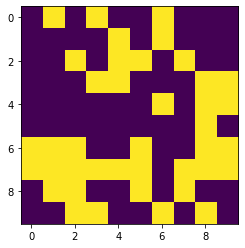

In [65]:
# Array of NxN spins, up or down (+1 or -1)
N = 10
spins = np.random.choice([-1, 1], size = (N, N))
plt.imshow(spins)

In [75]:
from numba import jit

@jit(nopython = True)
def dE(i, j, spins):
    # This function calculates the change in energy
    # from flipping a spin
    Nx = spins.shape[0]
    Ny = spins.shape[1]
    J = 1
    s = -spins[i,j]
    return -J * s * (
        spins[i-1, j] + spins[(i+1) % Nx, j] +
        spins[i, j-1] + spins[i, (j+1) % Ny] )


# This function receives a considerable speedup
# from just-in-time compilation with numba, as
# it contains a for-loop. The effect of jit-compiling
# the function dH above isn't as large, but it is
# required as one cannot call a non-compiled function
# from within a compiled function.
@jit(nopython = True)
def sweep(spins, T):
    # This function carries out a "sweep" over the grid,
    # in the sense that it tries to flip each spin once
    # on average, rejecting the flip with a certain probability
    # which depends on temperature and change in energy
    for i in range(spins.size):
        i = np.random.randint(0, spins.shape[0])
        j = np.random.randint(0, spins.shape[1])
        r = np.random.random()
        w = np.exp(-dE(i,j,spins)/T)
        if w > r:
            spins[i,j] = -spins[i,j]
    return spins


def average(spins):
    return np.sum(spins) / spins.size


def run(Nspins, Nsweeps, T):
    # This function carries out one simulation:
    # Initialise a random grid
    # Carry out a number of sweeps, until the system
    # can be assumed to have reached equilibrium
    # Then return the average spin
    # (which is proportional to the bulk magnetisation)
    spins = np.random.choice([-1, 1], size = (Nspins, Nspins))
    for i in range(Nsweeps):
        spins = sweep(spins, T)
    return spins

In [84]:
Nspins = 10
Nsweeps = 1000
T = 10

spins = run(Nspins, Nsweeps, T)

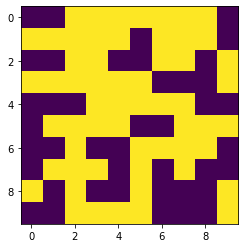

In [85]:
plt.imshow(spins.astype(np.float64))

In [89]:
from tqdm import tqdm

# Set up grid size, then run a bunch of simulations
# for increasing temperature
Nspins  = 40
Nsweeps = 500
Temps   = np.linspace(0.1, 2, 250)
Moments = np.zeros_like(Temps)

iout = 0
for i,T in tqdm(enumerate(Temps), total = len(Temps)):
    Moments[i] = np.mean(run(Nspins, Nsweeps, T))

100%|██████████| 250/250 [00:09<00:00, 25.09it/s]


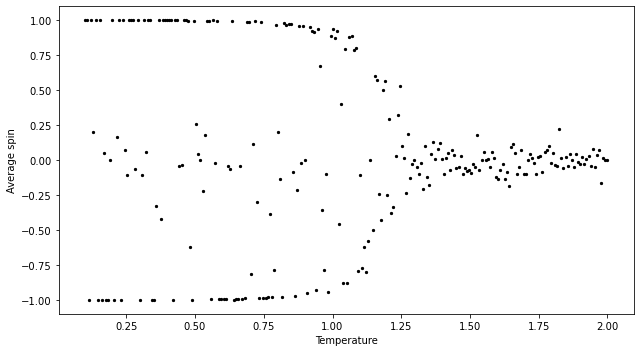

In [90]:
# Plot of average spin agains temperature
# reveals a pitchfork bifurcation.
fig = plt.figure(figsize = (9,5))
plt.scatter(Temps, Moments, c = 'k', s = 5)
plt.xlabel('Temperature')
plt.ylabel('Average spin')
plt.tight_layout()

## Look at the Markov chain of average spins

In [91]:
def run_full(Nspins, Nsweeps, T):
    # This function carries out one simulation:
    # Initialise a random grid
    # Carry out a number of sweeps, until the system
    # can be assumed to have reached equilibrium
    # Then return the average spin
    # (which is proportional to the bulk magnetisation)
    spins = np.random.choice([-1, 1], size = (Nspins, Nspins))
    magnetisation = np.zeros(Nsweeps)
    for i in range(Nsweeps):
        spins = sweep(spins, T)
        magnetisation[i] = np.mean(spins)
    return spins, magnetisation

In [96]:
# Set up grid size, then run a bunch of simulations
Nspins  = 40
Nsweeps = 1000
T = 1

spins, magnetisation = run_full(Nspins, Nsweeps, T)

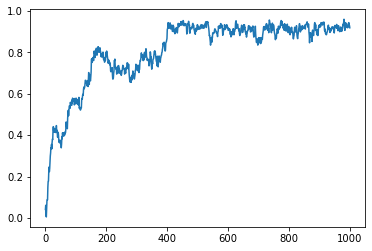

In [97]:
plt.plot(magnetisation)